In [136]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location

In [137]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from utils.formate_matrix_toMLData import *
from models.model_0929 import *
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams["font.size"] = 22
np.set_printoptions(suppress=True)
import seaborn as sns

In [ ]:
formater = formate_dataMatrix()

# 読み込む対象の拡張子（例: .csv のみに限定）
VALID_EXTENSIONS = (".csv", ".txt")
IGNORED_PREFIXES = ("._", ".DS_Store", "Thumbs.db")

# ファイルを処理する関数
def process_file(file_path, states_sets, delt_sets, true_sets,targets_sets,ll_use):
    try:
        print("Processing:", file_path)
        with open(file_path, 'rb') as f:
            all_matrix = np.loadtxt(f, delimiter=",")

        tm = matrix_trimer(all_matrix)
        true_trm = tm.trim_transitionRateMatrix(start = 0, end = 4)
        true_vec = np.array(formater.GetOutputVector_byDiagonal(true_trm))
        data = []
        if ll_use:
            
            ll_trm = tm.trim_transitionRateMatrix(start = 4, end = 8)
            ll_vec = np.array(formater.GetOutputVector_byDiagonal(ll_trm))
            data = tm.trim_data(start = 8)
        else:
            data = tm.trim_data(start = 4)
            ll_vec = np.array([0,0,0])
            
        print(data)
        # state: shape (2, num_samples_i)
        state = np.stack([data[:, 0], data[:, 1]], axis=0)
        states_sets.append(state)
        delt_sets.append(data[:, 2])
        true_sets.append(true_vec)
        targets_sets.append(ll_vec)

    except Exception as e:
        print(f"❌ Skipping file: {file_path} (Reason: {e})")

# ディレクトリ内のファイルを一括処理
def process_all_files_in_directory(directory, func, states_sets, delt_sets, true_sets,targets_sets,ll_use = True):
    for filename in os.listdir(directory):
        if filename.startswith(IGNORED_PREFIXES):
            continue
        if not filename.endswith(VALID_EXTENSIONS):
            continue

        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            func(file_path,states_sets, delt_sets, true_sets,targets_sets,ll_use)



## モデル読み込み

In [139]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = DeepSets_varSets_forDiagnel(device=device)
model.load_state_dict(torch.load("../model_weights/mixed_distribution/mixed_0929.pth", map_location=device))
model.eval()

class all_lifespan_loss(nn.Module):
    def forward(self, outputs, targets):
        
        y_pred_inverse = 1.0 / (outputs)
        y_true_inverse = 1.0 / (targets)

        # 逆数の差の絶対値
        loss_tensor = torch.abs(y_pred_inverse - y_true_inverse)[0]
        return loss_tensor, y_true_inverse[0], y_pred_inverse

criterion = all_lifespan_loss()

/tmp/ipykernel_34997/1224995175.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../model_weights/mixed_distribution/mixed_0929.pth", ma

## モデルの検証

In [140]:
test_states = []
test_del_t = []
test_targets = []
dummy = []
data_dir = "/media/user/TRANSCEND/datas/discrete_test"
# 実行
process_all_files_in_directory(data_dir,process_file, test_states, test_del_t,test_targets,dummy,False)


Processing: /media/user/TRANSCEND/datas/discrete_test/11_10000_4.csv
[[ 2.   3.  62.9]
 [ 2.   4.  90.6]
 [ 2.   4.  90.6]
 ...
 [ 2.   4.  62.9]
 [ 2.   4.  62.9]
 [ 2.   4.  62.9]]
Processing: /media/user/TRANSCEND/datas/discrete_test/8_10000_4.csv
[[ 2.   3.  60.8]
 [ 2.   3.   8.2]
 [ 1.   3.  95.2]
 ...
 [ 2.   3.  25.8]
 [ 2.   3.  60.8]
 [ 1.   3.  95.2]]
Processing: /media/user/TRANSCEND/datas/discrete_test/15_10000_4.csv
[[ 3.   3.  16.6]
 [ 3.   3.  16.6]
 [ 3.   4.  84.3]
 ...
 [ 3.   4.  66.4]
 [ 1.   4.  37.9]
 [ 3.   4.  37.2]]
Processing: /media/user/TRANSCEND/datas/discrete_test/20_10000_4.csv
[[ 2.   3.  74.1]
 [ 1.   2.  11.7]
 [ 3.   4.  74.1]
 ...
 [ 2.   4.  74.1]
 [ 2.   2.  74.1]
 [ 2.   2.  74.1]]
Processing: /media/user/TRANSCEND/datas/discrete_test/17_10000_4.csv
[[ 3.   4.  71. ]
 [ 3.   4.  66.3]
 [ 3.   3.  17. ]
 ...
 [ 2.   3.  71. ]
 [ 3.   4.  94.4]
 [ 3.   4.  59. ]]
Processing: /media/user/TRANSCEND/datas/discrete_test/4_10000_4.csv
[[ 1.   1.   1.3]


,ll,pred,loss
0,46.943066,46.683937,0.259129
1,87.444626,86.936668,0.507957
2,54.246563,53.989986,0.256577
3,63.302605,63.421738,0.119133
4,66.270409,66.270508,0.000099
...,...,...,...
2995,11.617315,13.182405,1.565089
2996,42.277325,39.959812,2.317513
2997,85.396713,86.504837,1.108124
2998,26.793539,26.159134,0.634405


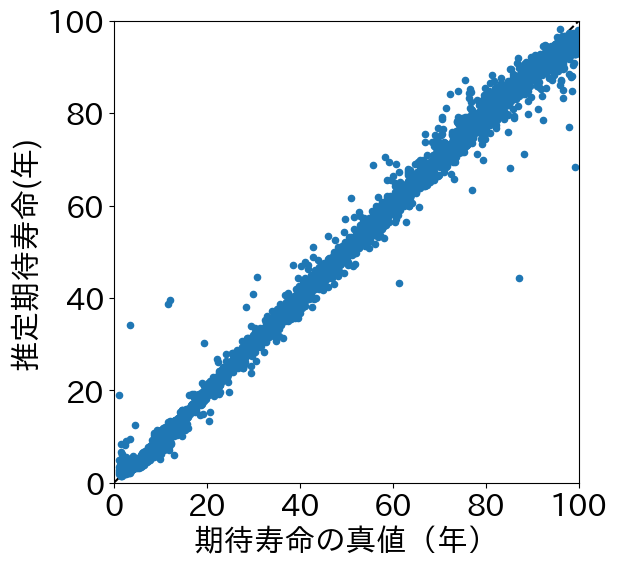

In [141]:
# データセットとデータローダーの作成
test_dataset = varSets_Datasets(test_states, test_del_t, test_targets)
use_cuda = torch.cuda.is_available()
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=use_cuda,
)
data_iter = iter(test_dataloader)

loss_list = []
outs_lifespan = []
true_lifespan = []

for states, delta_t, targets, lengths in data_iter:
    with torch.no_grad():
        states = states.to(device, non_blocking=True).long()
        delta_t = delta_t.to(device, non_blocking=True).float()
        targets = targets.to(device, non_blocking=True).float()
        lengths = lengths.to(device, non_blocking=True).long()

        outputs = model(states, delta_t, lengths)[0]
        loss_tensor, true_expect, pred_expect = criterion(outputs, targets)

        true_expect_cpu = true_expect.detach().cpu()
        pred_expect_cpu = pred_expect.detach().cpu()
        batch_loss = torch.abs(true_expect_cpu - pred_expect_cpu)

        true_lifespan.extend(true_expect_cpu.tolist())
        outs_lifespan.extend(pred_expect_cpu.tolist())
        loss_list.extend(batch_loss.tolist())
        
        
df = pd.DataFrame({
        "ll": true_lifespan,
        "pred": outs_lifespan,
        "loss": loss_list,
    })
display(df)

plt.figure(figsize=(6,6))
x = np.linspace(0, 100, 1000)
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("期待寿命の真値（年）")
plt.ylabel("推定期待寿命(年)")
plt.plot(x,x,color="#000000", linestyle = '--',zorder= 0)

plt.scatter(df["ll"],df["pred"],s = 20,)
# plt.scatter(df["true"],df["pred"],color = "#d69c6a",edgecolors="#d79e6b",s = 20,  zorder= 1)
plt.show()

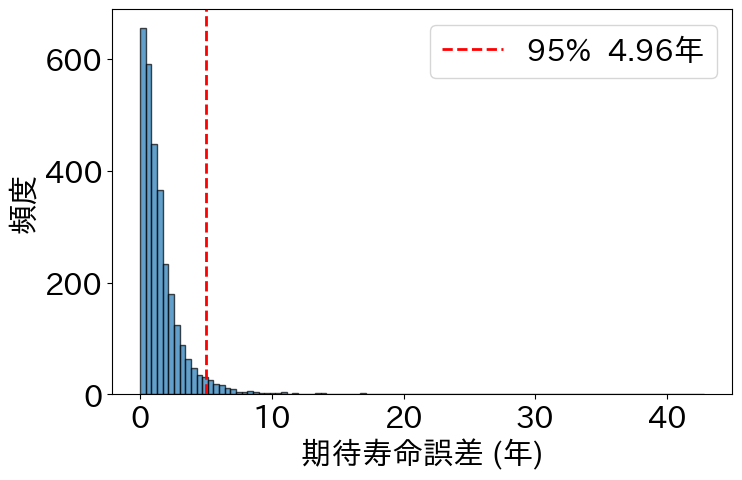

In [142]:
p95 = np.percentile(df["loss"], 95)

plt.figure(figsize=(8, 5))
plt.hist(df["loss"], bins=100, edgecolor="black", alpha=0.7)
plt.axvline(p95, color="red", linestyle="--", linewidth=2, label=f"95%  {p95:.2f}年")


plt.xlabel("期待寿命誤差 (年)")
plt.ylabel("頻度")
# plt.title("Histogram of Loss with 95th Percentile")
plt.legend()
plt.show()

## データセットのサイズ別の推論結果

In [143]:
#データセットごとの読み込み
dataset_list = [200,400,600,800,1000]
states_sets = []
del_t_sets = []
true_sets = []
targets_sets = []
for dataset_size in dataset_list:
    data_dir = f"/media/user/TRANSCEND/datas/testdata_n{str(dataset_size)}"
    states = []
    del_ts = []
    trues = []
    targets = []
    process_all_files_in_directory(data_dir,process_file, states, del_ts, trues,targets)
    states_sets.append(states)
    del_t_sets.append(del_ts)
    true_sets.append(trues)
    targets_sets.append(targets)

Processing: /media/user/TRANSCEND/datas/testdata_n200/23_200_4.csv
[[ 3.   4.  28.7]
 [ 3.   3.   2.9]
 [ 3.   4.  83.8]
 [ 1.   1.  55.1]
 [ 3.   4.  83.8]
 [ 3.   3.  48.7]
 [ 3.   4.  83.8]
 [ 3.   3.  83.8]
 [ 3.   3.  28.7]
 [ 1.   1.  83.8]
 [ 3.   3.  48.7]
 [ 3.   4.  83.8]
 [ 1.   1.  48.7]
 [ 1.   1.   2.9]
 [ 3.   4.  48.7]
 [ 3.   3.   2.9]
 [ 3.   4.  83.8]
 [ 3.   3.  83.8]
 [ 3.   3.   2.9]
 [ 2.   2.   2.9]
 [ 3.   3.  83.8]
 [ 3.   4.  83.8]
 [ 3.   3.   2.9]
 [ 3.   3.   2.9]
 [ 3.   4.  83.8]
 [ 3.   4.  83.8]
 [ 3.   4.  28.7]
 [ 3.   3.  83.8]
 [ 3.   3.   9.8]
 [ 1.   2.  83.8]
 [ 1.   1.   9.8]
 [ 3.   4.  83.8]
 [ 3.   3.   9.8]
 [ 1.   2.   9.8]
 [ 1.   1.   2.9]
 [ 3.   3.   2.9]
 [ 3.   3.  55.1]
 [ 3.   4.  83.8]
 [ 3.   4.  55.1]
 [ 3.   4.  71.6]
 [ 3.   4.  83.8]
 [ 3.   4.  48.7]
 [ 3.   3.  55.1]
 [ 1.   3.  28.7]
 [ 3.   3.   9.8]
 [ 3.   4.  83.8]
 [ 3.   4.  83.8]
 [ 1.   1.   9.8]
 [ 3.   4.  83.8]
 [ 3.   3.  48.7]
 [ 1.   1.   9.8]
 [ 3.   4.  83.

In [144]:
#データセットごとの推論
loss_lists = []
outs_lifespan_sets = []
ll_lifespan_sets = []
true_lifespan_sets = []

for i in range(len(dataset_list)):
    true_lifespan = []
    for j in range(len(true_sets[i])):
        
        for k in range(3):
            true_lifespan.append(1/true_sets[i][j][k])
        
    true_lifespan_sets.append(true_lifespan)

for i in range(len(dataset_list)):
    states = states_sets[i]
    del_ts = del_t_sets[i]
    targets = targets_sets[i]

    test_dataset = varSets_Datasets(states, del_ts, targets)
    use_cuda = torch.cuda.is_available()
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        pin_memory=use_cuda,
    )
    data_iter = iter(test_dataloader)
    print(len(data_iter))
    loss_list = []
    outs_lifespan = []
    ll_lifespan = []

    for states, delta_t, targets, lengths in data_iter:
        with torch.no_grad():
            states = states.to(device, non_blocking=True).long()
            delta_t = delta_t.to(device, non_blocking=True).float()
            targets = targets.to(device, non_blocking=True).float()
            lengths = lengths.to(device, non_blocking=True).long()

            outputs = model(states, delta_t, lengths)[0]
            loss_tensor, true_expect, pred_expect = criterion(outputs, targets)
            # print("===")
            # print("---")
            # print(loss_tensor,true_expect, pred_expect)
            ll_expect_cpu = true_expect.detach().cpu()
            pred_expect_cpu = pred_expect.detach().cpu()
            batch_loss = torch.abs(ll_expect_cpu - pred_expect_cpu)
            # print("---")
            # print(ll_expect_cpu,pred_expect_cpu,batch_loss)
            ll_lifespan.extend(ll_expect_cpu.tolist())
            outs_lifespan.extend(pred_expect_cpu.tolist())
            loss_list.extend(batch_loss.tolist())

    loss_lists.append(loss_list)
    outs_lifespan_sets.append(outs_lifespan)
    ll_lifespan_sets.append(ll_lifespan)

200
200
200
200
200


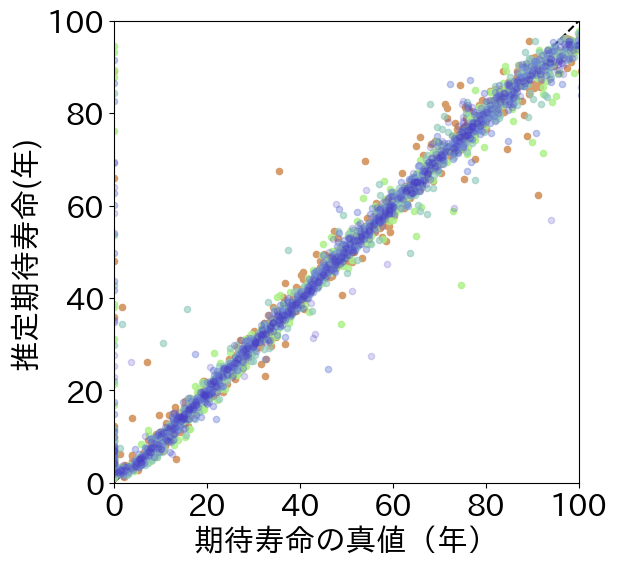

In [145]:
plt.figure(figsize=(6,6))
x = np.linspace(0, 100, 1000)
color_list = ["#d69c6a", "#acf087", "#8fc8bb", "#6a7ed6", "#493bc4"]
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("期待寿命の真値（年）")
plt.ylabel("推定期待寿命(年)")
plt.plot(x,x,color="#000000", linestyle = '--',zorder= 0)
for i in range(len(dataset_list)):
    df = pd.DataFrame({
        "ll": ll_lifespan_sets[i],
        "pred": outs_lifespan_sets[i],
        "loss": loss_lists[i],
    })
    plt.scatter(df["ll"],df["pred"],color = color_list[i],edgecolors=color_list[i],s = 20,  alpha=0.2*(5-i))

plt.show()


In [146]:
gap_ll = []
gap_eval = []
for i in range(len(dataset_list)):
    l = []
    e = []
    for j in range(len(true_lifespan_sets[i])):
        
        e.append(abs(true_lifespan_sets[i][j]-outs_lifespan_sets[i][j]))
        l.append(abs(true_lifespan_sets[i][j]-ll_lifespan_sets[i][j]))
        
    gap_ll.append(l)
    gap_eval.append(e)
            

filtered_gap_ll = []
filtered_gap_eval = []
for i in range(len(dataset_list)):
    temp_ll = np.array(gap_ll[i])
    temp_eval = np.array(gap_eval[i])
    lower = np.percentile(temp_ll, 0)
    upper = np.percentile(temp_ll, 95)
    mask = (temp_ll >= lower) & (temp_ll <= upper)
    filtered_ll = temp_ll
    filterd_eval = temp_eval
    # filterd_eval = temp_eval
    filtered_gap_ll.append(filtered_ll)
    filtered_gap_eval.append(filterd_eval)    

200 600 600
400 600 600
600 600 600
800 600 600
1000 600 600


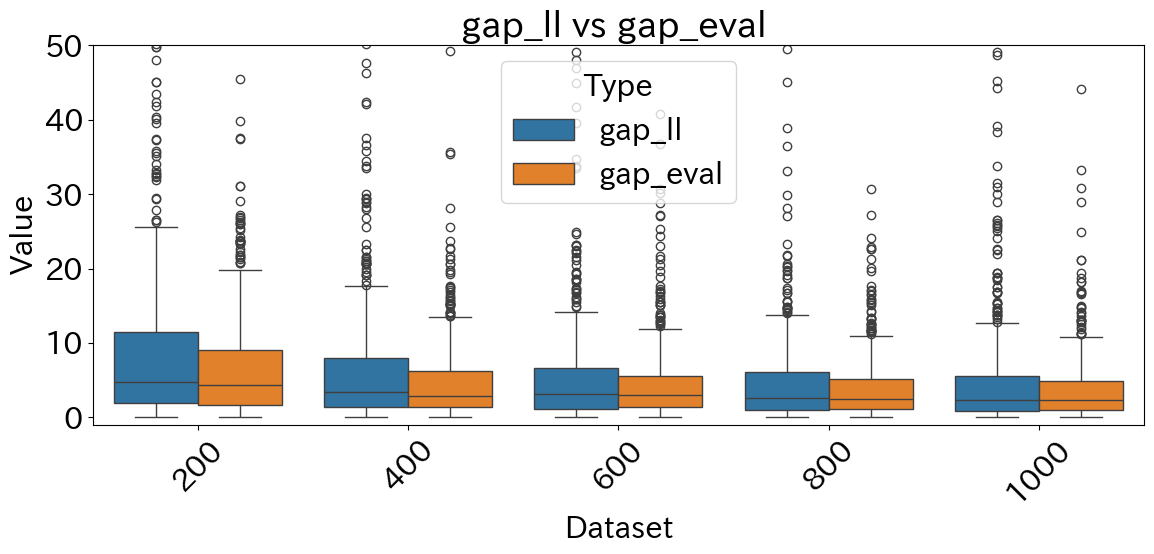

In [147]:
# ---- Violinプロット用にデータを整形 ----
plot_data = []
for label, ll_vals, ev_vals in zip(dataset_list, filtered_gap_ll, filtered_gap_eval):
    print(label,len(ll_vals),len(ev_vals))
    for v in ll_vals:
        plot_data.append({"Dataset": label, "Value": v, "Type": "gap_ll"})
        
    for v in ev_vals:
        plot_data.append({"Dataset": label, "Value": v, "Type": "gap_eval"})
    
    

df = pd.DataFrame(plot_data)

# ---- Violin plot 横並び ----
plt.figure(figsize=(12, 6))
# sns.violinplot(data=df, x="Dataset", y="Value", hue="Type", split=True)
sns.boxplot(data=df, x="Dataset", y="Value", hue="Type")
plt.ylim((-1,50))
plt.title("gap_ll vs gap_eval ")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 